## __XDF latency analysis of LSL data streams: Unity (triggered) vs EEG (measured)__

### __Situation__ 
#### Every 500ms a beep sound is played and the background color changes one frame from black to white.

#### __Unity (90 FPS):__
- Color change (black or white background)
- Beep sound (audio playing or not)

#### __EEG (1024 Hz):__
- Photodiode (light sensor)
- Microphone (audio sensor)


#### __TODO__
* [x] Read XDF file and header and select the right data (timestamps and values)
* [x] Compute the timestamps from 0
* [x] Visualize the data: unity audio vs microphone and unity color vs photodiode
* [x] Compare the timestamps (length, duration, sample count..): Original vs Calculated vs FileInfo
* [x] Descriptive statistics of timestamps distribution and plot
* [x] Actual latency test: select the microphone and photodiode peaks (starting points) and compare with the unity ones
* [x] Test all recordings
* [x] Make and test long recordings (half an hour) and check with two computers (local network setup)
* [ ] Find out why sometimes Unity timestamps start before the EEG ones
* [ ] Find out why sometimes there are two Diode spikes during one colour change
* [ ] ...

#### __Dependencies__

In [2]:
import copy
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyxdf
from scipy.signal import find_peaks
import seaborn as sns

#### __Files (recordings)__

In [3]:
files = os.listdir("data")  # get all files from the folder "data"
files.sort()  # sort them alphabetically
recordings = {}

for file in files:
    if file.startswith("."):  # filter hidden/config files
        files.remove(file)  # remove hidden/config file

for i, file in enumerate(files):  # store and display all files
    recordings[i] = {"file": file}

recordings

{0: {'file': 'final_test.xdf'},
 1: {'file': 'ftest1.xdf'},
 2: {'file': 'ftest2.xdf'},
 3: {'file': 'ftest3.xdf'},
 4: {'file': 'ftest_build1.xdf'},
 5: {'file': 'ftest_build2.xdf'},
 6: {'file': 'ftest_build3.xdf'},
 7: {'file': 'ftest_lsl12.xdf'},
 8: {'file': 'long2.xdf'},
 9: {'file': 'long3.xdf'},
 10: {'file': 'long4.xdf'},
 11: {'file': 'short_new.xdf'},
 12: {'file': 'short_test.xdf'},
 13: {'file': 'short_test_old1.xdf'},
 14: {'file': 'test.xdf'}}

In [31]:
for k in recordings:
    print(f"{k}:{recordings[k]['file']}-> EEG host:{recordings[k]['eeg']['info']['hostname']} - Unity host:{recordings[k]['unity']['info']['hostname']}")
    print("")

0:final_test.xdf-> EEG host:wd-right - Unity host:westbrook

1:ftest1.xdf-> EEG host:westbrook - Unity host:westbrook

2:ftest2.xdf-> EEG host:westbrook - Unity host:westbrook

3:ftest3.xdf-> EEG host:westbrook - Unity host:westbrook

4:ftest_build1.xdf-> EEG host:westbrook - Unity host:westbrook

5:ftest_build2.xdf-> EEG host:westbrook - Unity host:westbrook

6:ftest_build3.xdf-> EEG host:westbrook - Unity host:westbrook

7:ftest_lsl12.xdf-> EEG host:westbrook - Unity host:westbrook

8:long2.xdf-> EEG host:VR5 - Unity host:westbrook

9:long3.xdf-> EEG host:VR5 - Unity host:westbrook

10:long4.xdf-> EEG host:VR5 - Unity host:westbrook

11:short_new.xdf-> EEG host:VR5 - Unity host:westbrook

12:short_test.xdf-> EEG host:VR5 - Unity host:westbrook

13:short_test_old1.xdf-> EEG host:VR5 - Unity host:westbrook

14:test.xdf-> EEG host:wd-right - Unity host:westbrook



#### __Helper functions__

In [4]:
# set pandas float display format
pd.options.display.float_format = "{:.5f}".format


def select_streams(streams):
    # stream names
    a_ch_name = "Audio"
    c_ch_name = "Diode"
    e_ch_name = "openvibeSignal"

    # get all current streams with their positions on the recording
    # example: {'Diode': 0, 'Audio': 1, 'openvibeSignal': 2}
    s_channels = {streams[i]["info"]["name"][0]: i for i in range(len(streams))}

    # store and return their positions
    a = s_channels[a_ch_name]  # unity audio stream channel
    c = s_channels[c_ch_name]  # unity color stream channel
    e = s_channels[e_ch_name]  # eeg stream channel (diode and microphone)
    return a, c, e


def correct_timestamps(ts):
    # calculate time values from 0
    corrected = [0]
    length = len(ts)
    [corrected.append(ts[i + 1] - ts[0]) for i in range(length) if i < length - 1]
    return np.array(corrected)

#### __Preprocess data. For each recording:__ 
1. Load XDF file (recording)
2. Store selected streams information
3. Store original timestamps
4. Compare streams first timestamp distance and order
5. Correct and store original timestamps
6. Store Unity values (audio playing and color changed)
7. Select and store EEG values (microphone and photodiode)

Result format:
```json
{
    'file': 'filename.xdf',
    'unity': {
        'info': {
            'name': '',
            'type': '',
            'nominal_srate': '',
            'effective_srate': '',
            'created_at': '',
            'hostname': '',
            'first_timestamp': '',
            'last_timestamp': '',
            'sample_count': ''
        },
        'time_stamps': array([]),
        'timestamps': array([]),
        'audio': array([]),
        'color': array([])
    },
    'eeg': {
        'info': {
            'name': '',
            'type': '',
            'nominal_srate': '',
            'effective_srate': '',
            'created_at': '',
            'hostname': '',
            'first_timestamp': '',
            'last_timestamp': '',
            'sample_count': ''
        },
        'time_stamps': array([]),
        'timestamps': array([]),
        'audio': array([], dtype=float32),
        'color': array([], dtype=float32)
    },
    'eeg_first': boolean,
    'lsl_error': boolean
}
```

In [5]:
for k in recordings:  # check all files
    file = recordings[k]["file"]  # current filename
    # add unity and eeg entries
    recordings[k]["unity"] = {}
    recordings[k]["eeg"] = {}

    # 1. Load the XDF file
    streams, fileheader = pyxdf.load_xdf(f"data/{file}")

    # select the data stream channels
    a_ch, c_ch, e_ch = select_streams(streams)

    # 2. Store selected stream info (only useful info)
    # keys to keep from streams[ch]["info"]
    i_keys = [
        "name",
        "type",
        "nominal_srate",
        "effective_srate",
        "created_at",
        "hostname",
    ]
    # keys to keep from streams[ch]["footer"]["info"]
    f_keys = ["first_timestamp", "last_timestamp", "sample_count"]
    # first add info dict for each stream
    recordings[k]["unity"] = {"info": {}}
    recordings[k]["eeg"] = {"info": {}}
    for key in i_keys:
        u_v = streams[a_ch]["info"][key]
        e_v = streams[e_ch]["info"][key]
        if type(u_v) == list and len(u_v) > 0:  # same for e_k, no need to check again
            # remove list format as 1-element lists
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v
    for key in f_keys:
        u_v = streams[a_ch]["footer"]["info"][key]
        e_v = streams[e_ch]["footer"]["info"][key]
        if type(u_v) == list and len(u_v) > 0:
            u_v = u_v[0]
            e_v = e_v[0]
        recordings[k]["unity"]["info"][key] = u_v
        recordings[k]["eeg"]["info"][key] = e_v

    # 3. Store timestamps
    streams[a_ch]["time_stamps"] = np.array(streams[a_ch]["time_stamps"])
    streams[e_ch]["time_stamps"] = np.array(streams[e_ch]["time_stamps"])
    recordings[k]["unity"]["time_stamps"] = streams[a_ch]["time_stamps"]
    recordings[k]["eeg"]["time_stamps"] = streams[e_ch]["time_stamps"]

    # 4. Compare streams first timestamp distance and order
    # store EEG received first (True/False)
    unity_first = streams[a_ch]["time_stamps"][0]
    eeg_first = streams[e_ch]["time_stamps"][0]
    time_diff = unity_first - eeg_first
    # if diff bigger than eeg sample distance (0.98ms), something went wrong
    recordings[k]["eeg_first"] = True if time_diff >= -0.00098 else False
    # if diff bigger than 1 second, timestamps are not aligned -> wrong recording
    recordings[k]["lsl_error"] = True if time_diff >= 1 else False

    # 5. Correct and store timestamps
    u_corrected = correct_timestamps(streams[a_ch]["time_stamps"])
    e_corrected = correct_timestamps(streams[e_ch]["time_stamps"])
    # recorrect unity timestamps with eeg starting at 0
    # shift values according to the diff: left (negative) or right (positive)
    u_corrected = np.array([i + time_diff for i in u_corrected])
    # store corrected timestamps (timestamps -> corrected, time_stamps -> original)
    recordings[k]["unity"]["timestamps"] = u_corrected
    recordings[k]["eeg"]["timestamps"] = e_corrected

    # 6. Store Unity values (audio playing and color changed)
    # format: [currentFrame, value, timestamp] -> we store value
    unity_a = np.transpose(streams[a_ch]["time_series"])[1]
    unity_c = np.transpose(streams[c_ch]["time_series"])[1]
    recordings[k]["unity"]["audio"] = unity_a.astype(int)
    recordings[k]["unity"]["color"] = unity_c.astype(int)

    # 7. Select and store EEG values (microphone and photodiode)
    # select microphone and diode values
    eeg = np.transpose(streams[e_ch]["time_series"])

    # microphone data can be on channels 69 and 70, select the right one
    eeg_audio = eeg[68] if max(eeg[68]) != 0.0 else eeg[69]

    # diode data can be on channels 65 and 66, select the right one
    eeg_color = eeg[64] if max(eeg[64]) != 0.0 else eeg[65]
    eeg_color = -eeg_color  # invert diode data polarity, easier to visualize

    # store them
    recordings[k]["eeg"]["audio"] = eeg_audio
    recordings[k]["eeg"]["color"] = eeg_color

Preprocessing result example (1 recording):

In [5]:
recordings[0]

{'file': 'final_test.xdf',
 'unity': {'info': {'name': 'Audio',
   'type': 'Markers',
   'nominal_srate': '0.0000000000000000',
   'effective_srate': 0,
   'created_at': '4067.204516800000',
   'hostname': 'westbrook',
   'first_timestamp': '4115.5524331',
   'last_timestamp': '8063.4971332',
   'sample_count': '355351'},
  'time_stamps': array([4099.21801588, 4099.2290968 , 4099.24081223, ..., 8047.1848181 ,
         8047.19593562, 8047.20704965]),
  'timestamps': array([2.42861001e-02, 3.53670245e-02, 4.70824561e-02, ...,
         3.94799109e+03, 3.94800221e+03, 3.94801332e+03]),
  'audio': array([0, 0, 0, ..., 1, 1, 1]),
  'color': array([0, 0, 0, ..., 0, 0, 0])},
 'eeg': {'info': {'name': 'openvibeSignal',
   'type': 'signal',
   'nominal_srate': '1024.000000000000',
   'effective_srate': 1023.9712270290479,
   'created_at': '4081.377413700000',
   'hostname': 'wd-right',
   'first_timestamp': '4099.2109981',
   'last_timestamp': '8047.1986213',
   'sample_count': '4042655'},
  'ti

#### __Which recordings look (apparently) good?__

In [35]:
# keys to check: 'eeg_first' and 'lsl_error'
print("Wrong recording (✗✗) or EEG received first (✔/✗):")
for k in recordings:
    file = recordings[k]["file"]
    if recordings[k]["lsl_error"]:
        print(f"✗✗ {k}:{file}")
    elif recordings[k]["eeg_first"]:
        print(f"✔ {k}:{file}")
    else:
        print(f"✗ {k}:{file}")

Wrong recording (✗✗) or EEG received first (✔/✗):
✔ 0:final_test.xdf
✔ 1:ftest1.xdf
✔ 2:ftest2.xdf
✔ 3:ftest3.xdf
✔ 4:ftest_build1.xdf
✔ 5:ftest_build2.xdf
✔ 6:ftest_build3.xdf
✗✗ 7:ftest_lsl12.xdf
✔ 8:long2.xdf
✗ 9:long3.xdf
✔ 10:long4.xdf
✗ 11:short_new.xdf
✔ 12:short_test.xdf
✔ 13:short_test_old1.xdf
✔ 14:test.xdf


In [37]:
print(recordings[9]["unity"]["time_stamps"])
print(recordings[9]["eeg"]["time_stamps"])

[13464.09599419 13464.10696655 13464.1180628  ... 15312.57869976
 15312.58983211 15312.60089616]
[13464.10425901 13464.1052356  13464.10621218 ... 15312.60957651
 15312.6105531  15312.61152968]


#### __Timestamps comparison: original (O) vs corrected (C) vs file info (I)__

In [7]:
stats = pd.DataFrame()  # create empty dataframe
for k in recordings:
    comparison = {}
    if not recordings[k]["lsl_error"]:
        file = recordings[k]["file"].split(".")[0]  # remove extension from filename

        o_c = {"time_stamps": "O", "timestamps": "C"}
        for key in list(o_c.keys()):  # avoid duplicate code with different keys
            # for original and corrected timestamps
            u_ts = recordings[k]["unity"][key]
            e_ts = recordings[k]["eeg"][key]
            u_first = u_ts[0]
            u_last = u_ts[-1]
            e_first = e_ts[0]
            e_last = e_ts[-1]
            u_length = u_last - u_first
            e_length = e_last - e_first

            val = o_c[key]

            comparison[f"First EEG ({val})"] = e_first
            comparison[f"First Unity ({val})"] = u_first
            comparison[f"Last EEG ({val})"] = e_last
            comparison[f"Last Unity ({val})"] = u_last
            comparison[f"Length EEG ({val})"] = e_length
            comparison[f"Length Unity ({val})"] = u_length
            comparison[f"Sample count EEG ({val})"] = len(e_ts)
            comparison[f"Sample count Unity ({val})"] = len(u_ts)
            comparison[f"Start diff ({val})"] = u_first - e_first
            comparison[f"Length diff ({val})"] = abs(u_length - e_length)

        # file info
        u_info = recordings[k]["unity"]["info"]
        e_info = recordings[k]["eeg"]["info"]
        i_u_first = u_info["first_timestamp"]
        i_u_last = u_info["last_timestamp"]
        i_e_first = e_info["first_timestamp"]
        i_e_last = e_info["last_timestamp"]
        i_e_length = float(i_e_last) - float(i_e_first)
        i_u_length = float(i_u_last) - float(i_u_first)

        comparison["First EEG (I)"] = i_e_first
        comparison["First Unity (I)"] = i_u_first
        comparison["Last EEG (I)"] = i_e_last
        comparison["Last Unity (I)"] = i_u_last
        comparison["Length EEG (I)"] = i_e_length
        comparison["Length Unity (I)"] = i_u_length
        comparison["Sample count EEG (I)"] = e_info["sample_count"]
        comparison["Sample count Unity (I)"] = u_info["sample_count"]
        comparison["Start diff (I)"] = float(i_u_first) - float(i_e_first)
        comparison["Length diff (I)"] = abs(i_u_length - i_e_length)
        comparison["Stream creation (EEG)"] = e_info["created_at"]
        comparison["Stream creation (Unity)"] = u_info["created_at"]

        # order keys alphabetically
        comparison = dict(sorted(comparison.items()))

        if stats.empty:  # first file
            stats = pd.DataFrame.from_dict(
                comparison, orient="index", columns=[file], dtype=float
            )
        else:
            current = pd.DataFrame.from_dict(
                comparison, orient="index", columns=[file], dtype=float
            )
            stats = pd.merge(stats, current, left_index=True, right_index=True)

display(stats)

,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,short_new,short_test,short_test_old1,test
First EEG (C),0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
First EEG (I),4099.21100,597683.74404,597824.31215,597976.03226,598491.29066,598677.04580,598964.45703,11538.20545,13464.11651,3091.88329,2896.84127,11521.82951,11151.32245,822.46499
First EEG (O),4099.19373,597683.72940,597824.29413,597976.01532,598491.27394,598677.02717,598964.43842,11538.18904,13464.10426,3091.86438,2896.82957,11521.81398,11151.30548,822.44579
First Unity (C),0.02429,0.00582,0.01060,0.01003,0.02726,0.02200,0.01224,0.02518,-0.00826,0.00633,-0.00508,0.00756,0.01519,0.00511
First Unity (I),4115.55243,597683.73523,597824.30474,597976.02536,598491.30121,598677.04918,598964.45067,5442.97078,7368.84314,75207.36781,75012.32277,5426.57825,5056.07948,838.82152
First Unity (O),4099.21802,597683.73522,597824.30473,597976.02535,598491.30120,598677.04917,598964.45066,11538.21422,13464.09599,3091.87072,2896.82450,11521.82154,11151.32067,822.45091
Last EEG (C),3948.01621,122.03219,138.53250,136.53252,125.03236,134.03251,145.03270,1803.03708,1848.50727,2140.51401,64.50038,3.02985,62.03155,76.53242
Last EEG (I),8047.19862,597805.74422,597962.80827,598112.53638,598616.29079,598811.04591,599109.45715,13341.21339,15312.59637,5232.36425,2961.31324,11524.82944,11213.32247,898.96092
Last EEG (O),8047.20994,597805.76159,597962.82663,598112.54783,598616.30631,598811.05969,599109.47112,13341.22612,15312.61153,5232.37840,2961.32995,11524.84383,11213.33702,898.97822
Last Unity (C),3948.01332,122.00596,138.50322,136.50310,124.52740,134.01885,145.50557,1803.02845,1848.49664,2140.50414,64.48826,3.00617,62.02069,76.50456


#### __Descriptive statistics: Unity and EEG samples time distance__

In [8]:
u_stats = pd.DataFrame()  # create empty dataframe
u_dist = []
e_dist = []
for k in recordings:
    if not recordings[k]["lsl_error"]:
        file = recordings[k]["file"].split(".")[0]  # remove extension from filename
        # corrected timestamps
        u_ts = recordings[k]["unity"]["timestamps"]
        e_ts = recordings[k]["eeg"]["timestamps"]
        # compute the time distance between samples
        u = [u_ts[i + 1] - u_ts[i] for i in range(len(u_ts) - 1)]
        e = [e_ts[i + 1] - e_ts[i] for i in range(len(e_ts) - 1)]
        u_dist.append(u)
        e_dist.append(e)
        # store as dataframe (easier to compute descriptive statistics)
        u = pd.DataFrame(np.array(u), columns=[file])
        e = pd.DataFrame(np.array(e), columns=[file])
        if u_stats.empty:  # first file
            u_stats = u.describe()
            e_stats = e.describe()
        else:  # after first file, merge current stats with previous acumulated stats
            u_stats = pd.merge(u_stats, u.describe(), left_index=True, right_index=True)
            e_stats = pd.merge(e_stats, e.describe(), left_index=True, right_index=True)

print("Unity:")
display(u_stats)
print("EEG:")
display(e_stats)

Unity:


,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,short_new,short_test,short_test_old1,test
count,355351.00000,10981.00000,12465.00000,12285.00000,11206.00000,12061.00000,13096.00000,162286.00000,166381.00000,192663.00000,5805.00000,270.00000,5581.00000,6886.00000
mean,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111
std,0.00091,0.00114,0.00114,0.00121,0.00127,0.00118,0.00125,0.00084,0.00084,0.00084,0.00086,0.00013,0.00107,0.00378
min,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00002,0.00003,0.01047,0.00002,0.00003
25%,0.01106,0.01102,0.01102,0.01102,0.01103,0.01102,0.01102,0.01107,0.01107,0.01107,0.01106,0.01106,0.01106,0.01097
50%,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01111,0.01113
75%,0.01116,0.01120,0.01120,0.01119,0.01119,0.01120,0.01120,0.01115,0.01115,0.01114,0.01115,0.01114,0.01116,0.01130
max,0.02297,0.02247,0.02283,0.02272,0.02234,0.02263,0.02518,0.02319,0.02303,0.02315,0.02223,0.01183,0.02260,0.03585


EEG:


,final_test,ftest1,ftest2,ftest3,ftest_build1,ftest_build2,ftest_build3,long2,long3,long4,short_new,short_test,short_test_old1,test
count,4042655.00000,124959.00000,141855.00000,139807.00000,128031.00000,137247.00000,148511.00000,1846271.00000,1892831.00000,2191839.00000,66047.00000,3103.00000,63519.00000,78367.00000
mean,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098
std,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
min,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098
25%,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098
50%,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098
75%,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098
max,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098,0.00098


#### __Violin plot of Unity samples time distribution__

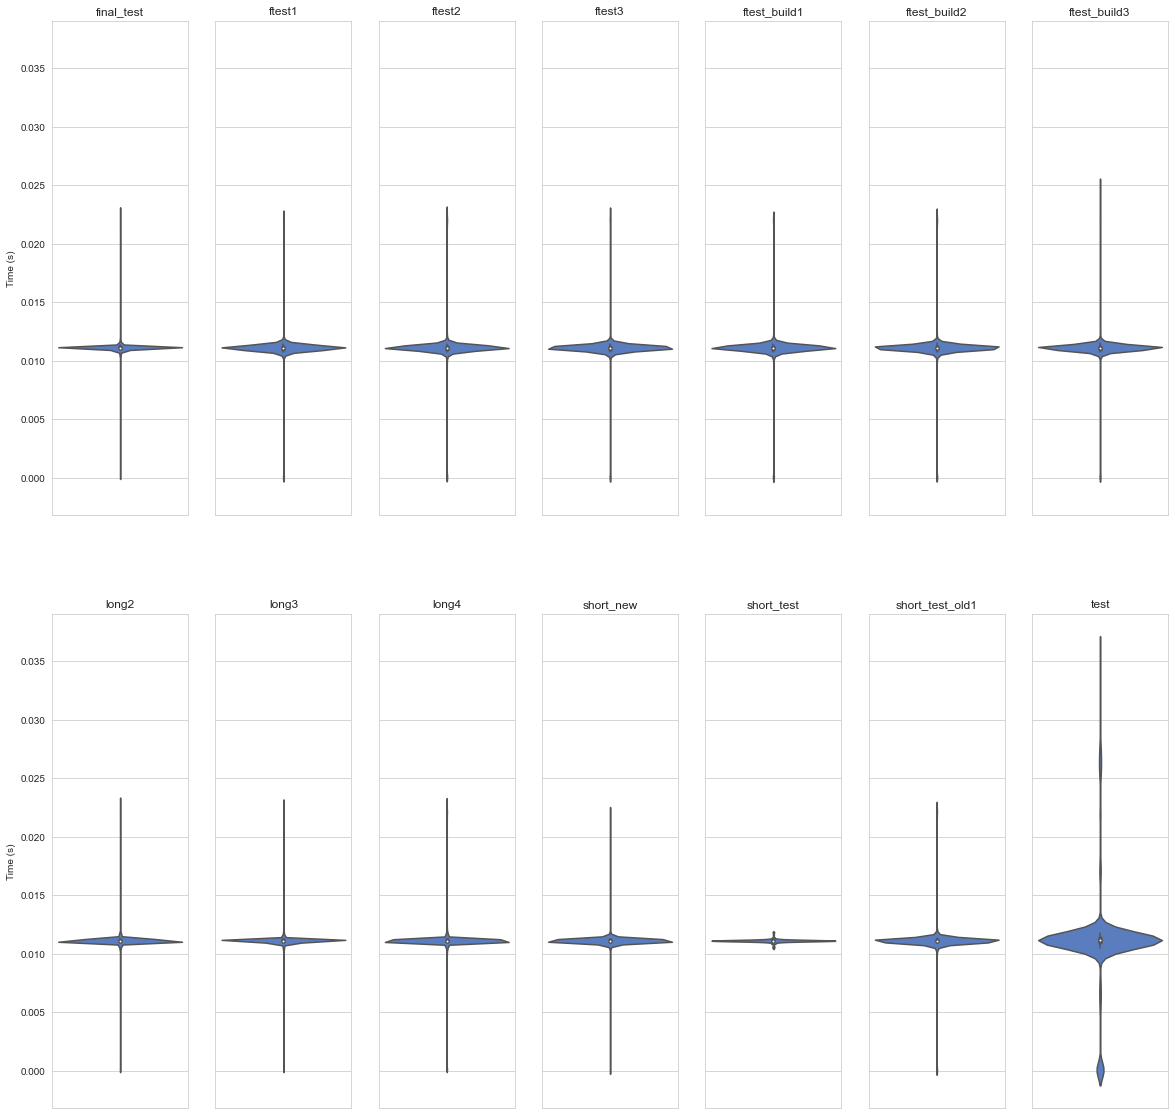

In [9]:
%matplotlib inline
sns.set_style("whitegrid")  # set seaborn plotting style
nplots = len(u_stats.columns)  # number of subplots
# define subplots
fig, axes = plt.subplots(nrows=2, ncols=int(nplots / 2), figsize=(20, 20), sharey=True)
# for all subplots (position[row, column] agnostic)
for i, ax in enumerate(axes.flat):
    fname = u_stats.columns[i]  # filename
    sns.violinplot(x=u_dist[i], orient="v", ax=ax, palette="muted")
    ax.set_title(fname)  # set subplot title as filename
# for each first subplot of each row
for ax in axes[:, 0]:
    ax.set_ylabel("Time (s)")  # set y-axis label

plt.show()

#### __Data preview__

How does the data look like? Plot of the 4 streams (Unity color, Unity audio, EEG diode, EEG microphone)

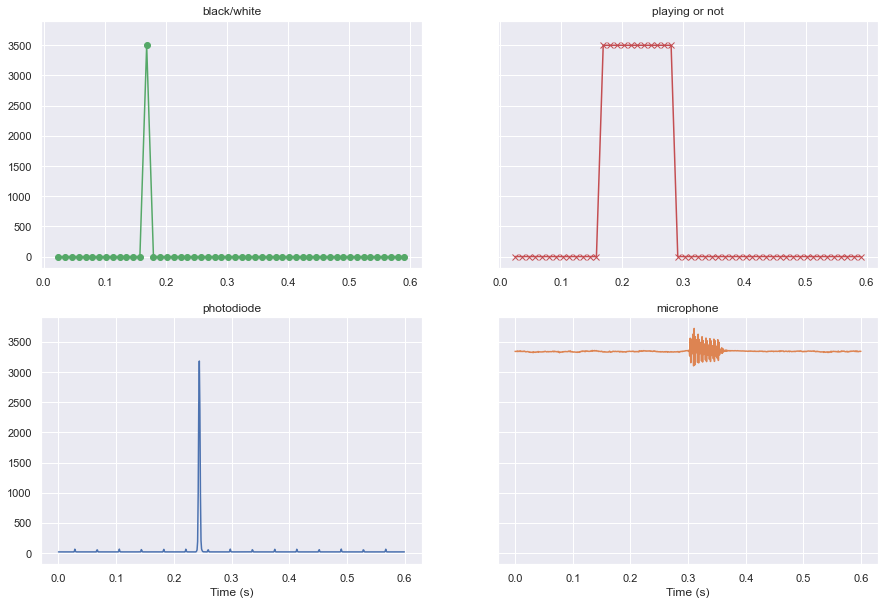

In [32]:
# interactive: widget, not interactive: inline
%matplotlib inline
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = -0.1  # starting point (s)
s_n = 0.6  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

k = 0
if not recordings[k]["lsl_error"]:
    file = recordings[k]["file"].split(".")[0]
    e = copy.deepcopy(recordings[k]["eeg"])
    u = copy.deepcopy(recordings[k]["unity"])
    e_t = e["timestamps"]
    u_t = u["timestamps"]
    e_a = e["audio"]
    e_c = e["color"]
    u_c = u["color"]
    u_a = u["audio"]
    # fix diff array sizes for unity color and audio arrays
    u_diff = len(u_c) - len(u_t)
    if u_diff > 0:
        # remove the diff from the end of the array
        u_c = u_c[:-u_diff]
    elif u_diff < 0:
        # add the diff from the end of the array
        for i in range(abs(u_diff)):
            u_c = np.append(u_c, u_c[-1])

    # select range of timestamps, diode and microphone values (eeg)
    e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
    e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
    e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

    # select range of timestamps, color and audio values (unity)
    u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
    u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
    u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]
    preview = [
        ["black/white", u_time_selection, u_color_selection * u_height],
        ["playing or not", u_time_selection, u_audio_selection * u_height],
        ["photodiode", e_time_selection, e_color_selection * 0.05],
        ["microphone", e_time_selection, e_audio_selection * 1.5],
    ]

    # plot the selected range to compare eeg vs unity values
    nplots = 5  # number of subplots
    
    # define colors, got from plt.gca().lines[-1].get_color() after each .plot call
    c_diode = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
    c_micro = (0.8666666666666667, 0.5176470588235295, 0.3215686274509804)
    c_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)
    c_audio = (0.7686274509803922, 0.3058823529411765, 0.3215686274509804)
    
    # define subplots
    fig, axes = plt.subplots(
        nrows=2, ncols=int(nplots / 2), figsize=(15, 10), sharey=True
    )
    axes[0,0].plot(preview[0][1], preview[0][2], marker="o", color=c_color)
    axes[0,0].set_title(preview[0][0])
    axes[0,1].plot(preview[1][1], preview[1][2], marker="x", color=c_audio)
    axes[0,1].set_title(preview[1][0])
    axes[1,0].plot(preview[2][1], preview[2][2], color=c_diode)
    axes[1,0].set_title(preview[2][0])
    axes[1,1].plot(preview[3][1], preview[3][2], color=c_micro)
    axes[1,1].set_title(preview[3][0])

    for ax in axes[1, :]:
        ax.set_xlabel("Time (s)")  # set x-axis label

    plt.show()
else:
    print("Wrong recording. No valuable plot")

Short preview of all recordings

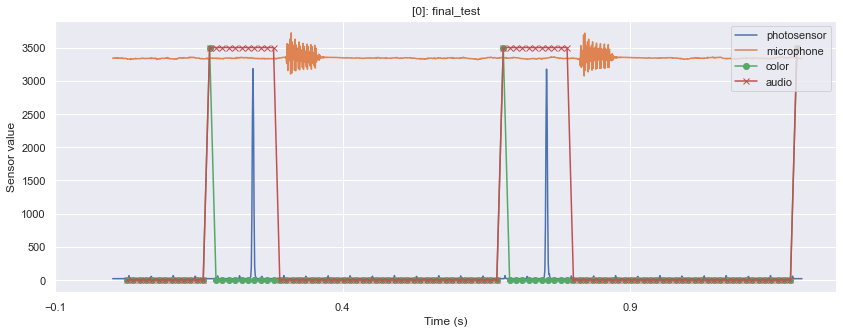

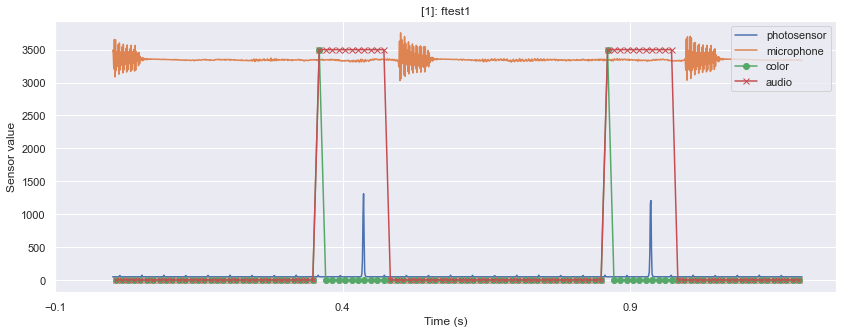

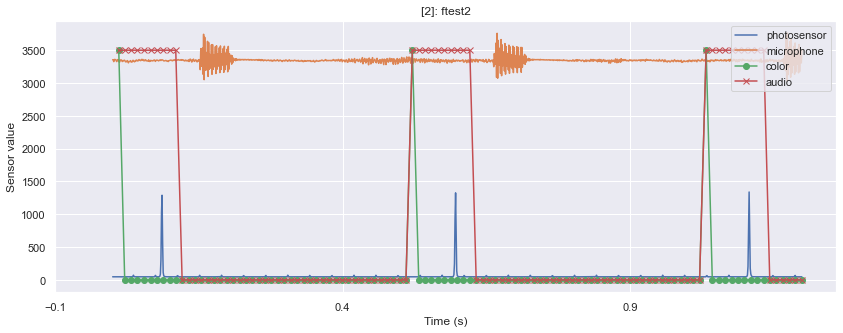

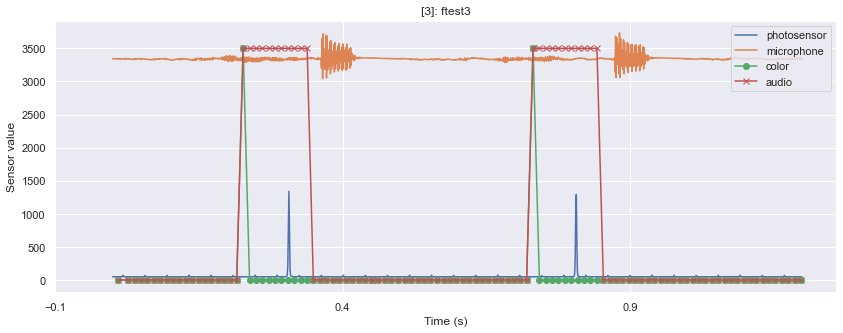

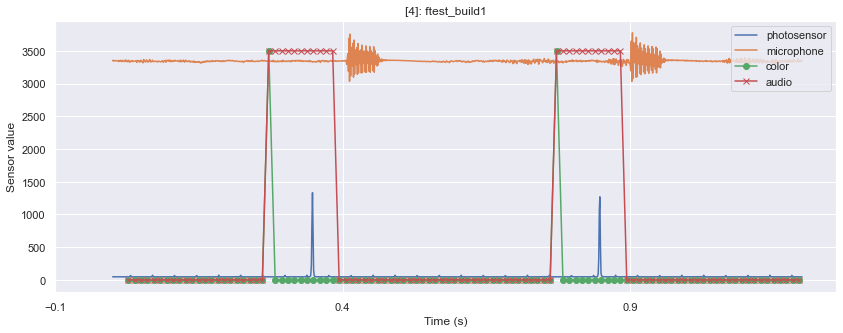

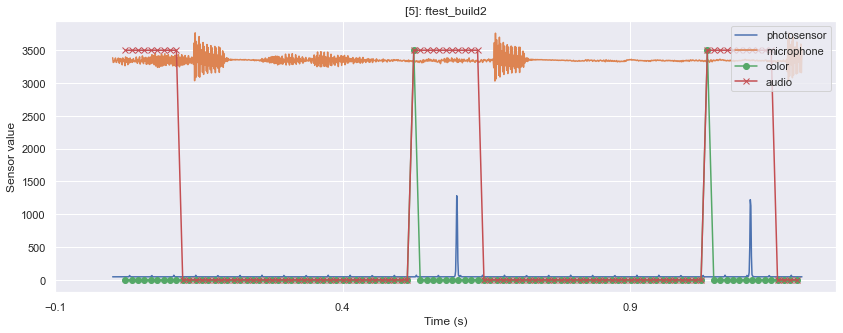

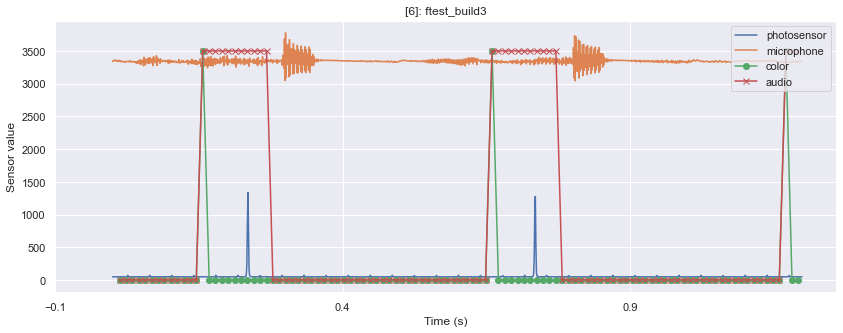

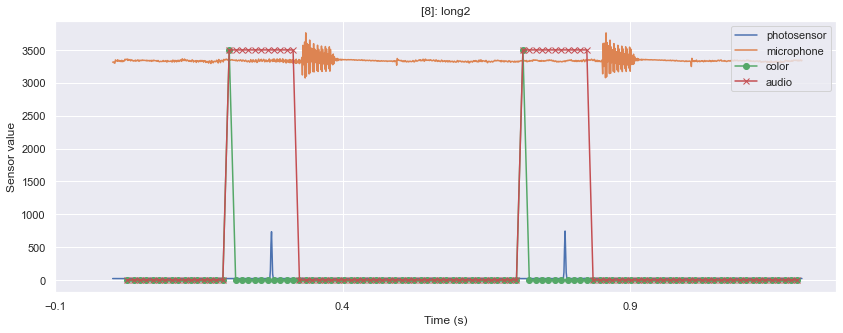

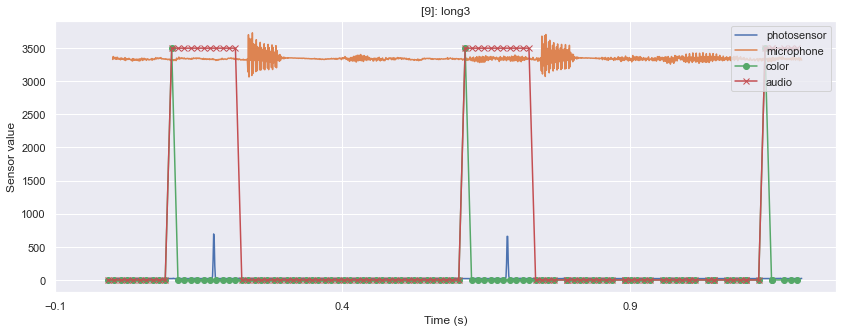

10:long4 -> u_c is 1 samples larger


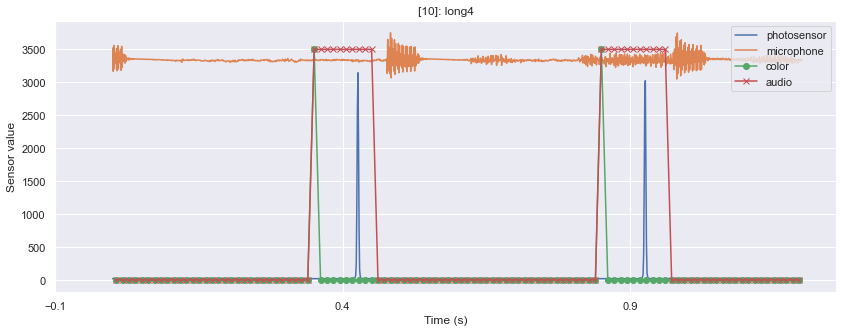

11:short_new -> u_c is 1 samples larger


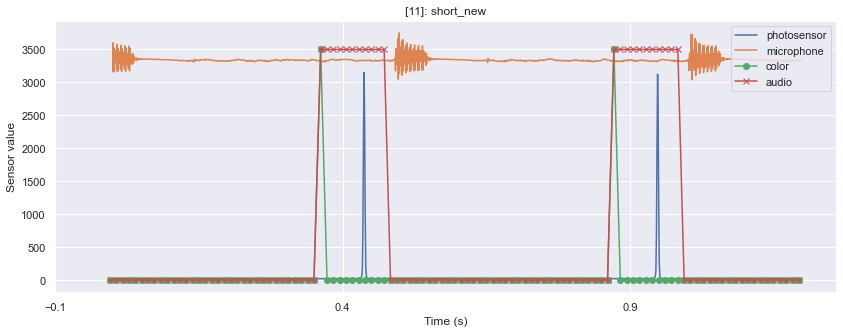

12:short_test -> u_c is 1 samples larger


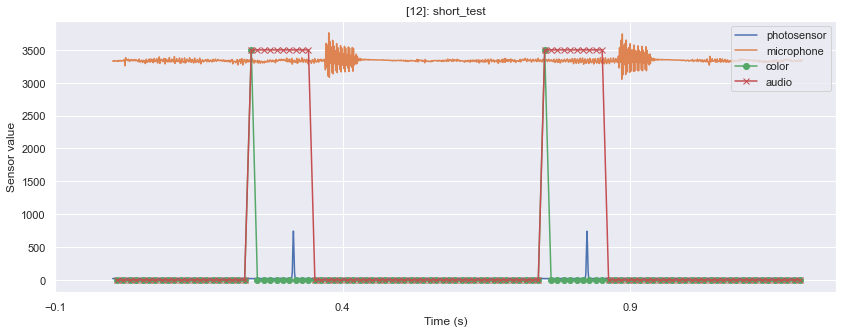

13:short_test_old1 -> u_c is 1 samples smaller


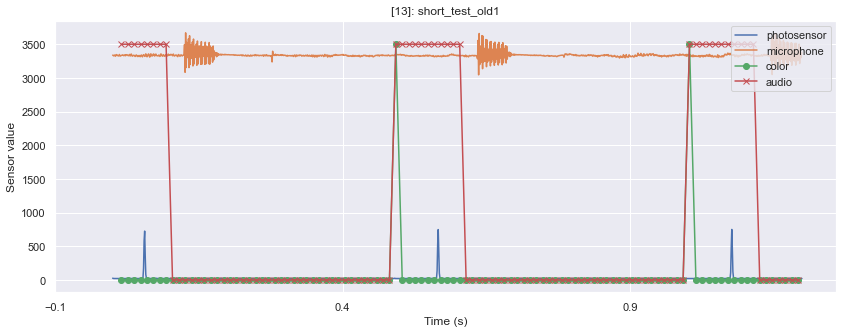

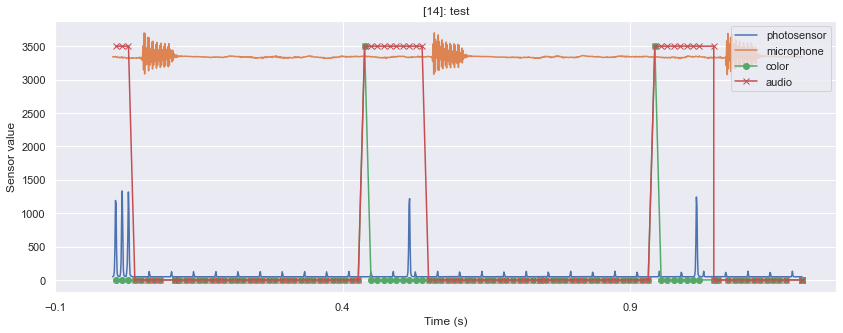

In [33]:
# interactive: widget, not interactive: inline
%matplotlib inline
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = -0.1  # starting point (s)
s_n = 1.2  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

e_samples = 1024 * s_n  # N of eeg in 5 s
u_samples = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization

for k in recordings:
    if not recordings[k]["lsl_error"]:
        file = recordings[k]["file"].split(".")[0]
        e = copy.deepcopy(recordings[k]["eeg"])
        u = copy.deepcopy(recordings[k]["unity"])
        e_t = e["timestamps"]
        u_t = u["timestamps"]
        e_a = e["audio"]
        e_c = e["color"]
        u_c = u["color"]
        u_a = u["audio"]
        # fix diff array sizes for unity color and audio arrays
        u_diff = len(u_c) - len(u_t)
        if u_diff > 0:
            print(f"{k}:{file} -> u_c is {u_diff} samples larger")
            # remove the diff from the end of the array
            u_c = u_c[:-u_diff]
        elif u_diff < 0:
            print(f"{k}:{file} -> u_c is {abs(u_diff)} samples smaller")
            # add the diff from the end of the array
            for i in range(abs(u_diff)):
                u_c = np.append(u_c, u_c[-1])

        # select range of timestamps, diode and microphone values (eeg)
        e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
        e_color_selection = e_c[(e_t > f_n) & (e_t < s_n)]
        e_audio_selection = e_a[(e_t > f_n) & (e_t < s_n)]

        # select range of timestamps, color and audio values (unity)
        u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
        u_color_selection = u_c[(u_t > f_n) & (u_t < s_n)]
        u_audio_selection = u_a[(u_t > f_n) & (u_t < s_n)]

        # plot the selected range to compare eeg vs unity values
        plt.plot(e_time_selection, e_color_selection * 0.05)
        plt.plot(e_time_selection, e_audio_selection * 1.5)
        plt.plot(u_time_selection, u_color_selection * u_height, marker="o")
        plt.plot(u_time_selection, u_audio_selection * u_height, marker="x")

        plt.title(f"[{k}]: {file}")
        plt.ylabel("Sensor value")
        plt.xlabel("Time (s)")
        plt.xticks(np.arange(f_n, s_n, step=0.5))
        labels = ["photosensor", "microphone", "color", "audio"]
        plt.legend(labels, loc="upper right")  # set the legend
        plt.show()

#### __Calculating the Latencies__

###### __Diode__

In [12]:
# get all the first peaks of each of the four recordings
e_col_peaks = find_peaks(e_color, height=10000, distance=400)
# here the len of unity is one longer than the len of
if nr_file == 11:
    u_col_peaks = find_peaks(u_color)
else:
    u_col_peaks = find_peaks(u_color[1])

# since we are only intersted in the position of the peaks not the height, lets only take the first column
ec_peak = e_col_peaks[0]
uc_peak = u_col_peaks[0]

# now we have the column where the peak occurs, now we need the corresponding time stamp
ec_time = [e_time[e] for e in ec_peak]
uc_time = [u_time[e] for e in uc_peak]

# calculate the differneces between EEG and unity
c_diff = np.empty(len(uc_time))
c_diff[:] = np.nan
c_diff = []
length = len(uc_time)
# to make sure we do not start with j = 0 if EEG starts before Unity
if np.array(uc_time)[0] > 0.25:
    j = 1
else:
    j = 0

for i in range(length):
    if (uc_time[i] - ec_time[j] > -0.25) and (uc_time[i] - ec_time[j] < 0):
        # add the difference between EEG and unity peak
        c_diff.append(uc_time[i] - ec_time[j])
        if j < len(ec_time):
            j = j + 1
    else:
        # add nan if there is no EEG peak
        c_diff.append(np.nan)

# check the nan values (and compare them to the graph)
nan_val = []
# get the indices of all nan values so we can check if there a diode is actually missing
nan_val.append(np.argwhere(np.isnan(c_diff)))
n = np.ravel(nan_val)  # to make it look nicer
# contains the untiy timestamps when the diode is missing --> to check in graph
time_st = np.array(uc_time)[np.array(n)]
print(time_st)

NameError: name 'e_color' is not defined

###### __Speaker__

In [ ]:
# get all the first peaks of each of the four recordings
e_audio_peaks = find_peaks(e_audio, height=2100, distance=400)
# here the len of unity is one longer than the len of
u_audio_peaks = find_peaks(u_audio[1])

# since we are only intersted in the position of the peaks not the height, lets only take the first column
ea_peak = e_audio_peaks[0]
ua_peak = u_audio_peaks[0]

# now we have the column where the peak occurs, now we need the corresponding time stamp
ea_time = [e_time[e] for e in ea_peak]
ua_time = [u_time[e] for e in ua_peak]

# calculate the differneces between EEG and unity
a_diff = []
length = len(ua_time)
# to make sure we do not start with j = 0 if EEG starts before Unity
if np.array(uc_time)[0] > 0.25:
    j = 1
else:
    j = 0
for i in range(length):
    if (ua_time[i] - ea_time[j] > -0.3) and (ua_time[i] - ea_time[j] < 0):
        # print(uc_time[i] - ec_time[j])
        a_diff.append(ua_time[i] - ea_time[j])
        if j < len(ea_time):
            j = j + 1
    else:
        a_diff.append(np.nan)

nan_val = []
# get the indices of all nan values so we can check if there a diode is actually missing
nan_val.append(np.argwhere(np.isnan(a_diff)))
n = np.ravel(nan_val)  # to make it look nicer
# contains the untiy timestamps when the diode is missing --> to check in graph
time_st = np.array(ua_time)[np.array(n)]
print(time_st)

#### __Data Preview__ 

In [ ]:
# interactive: widget, not interactive: inline
%matplotlib inline
sns.set(rc={"figure.figsize": (14, 5)})  # set figure size
sns.set_style("darkgrid")  # set seaborn plotting style

f_n = 0.2  # starting point (s)
s_n = 0.5  # ending point (s)

start_e = 1024 * f_n  # eeg sampling rate = 1024
start_u = 90 * f_n  # unity sampling rate = 90

five_sec = 1024 * s_n  # N of eeg in 5 s
f_sec = 90 * s_n  # N of unity in 5 s
u_height = 3500  # factor to improve unity (true/1) values visualization
e_t = np.array(e_time)
u_t = np.array(u_time)

# select range of timestamps, diode and microphone values (eeg)
e_time_selection = e_t[(e_t > f_n) & (e_t < s_n)]
e_color_selection = e_color[(e_t > f_n) & (e_t < s_n)]
e_audio_selection = e_audio[(e_t > f_n) & (e_t < s_n)]

# select a range of timestamps, color and audio values (unity)
u_time_selection = u_t[(u_t > f_n) & (u_t < s_n)]
u_color_selection = u_color[(u_t > f_n) & (u_t < s_n)]
u_audio_selection = u_audio[1][(u_t > f_n) & (u_t < s_n)]

# plot the selected range to compare eeg vs unity values
plt.plot(e_time_selection, e_color_selection * 0.05)
plt.plot(e_time_selection, e_audio_selection)
plt.plot(u_time_selection, u_color_selection * u_height, marker="o")
plt.plot(u_time_selection, u_audio_selection * u_height, marker="x")

plt.title(f"Sample: N = {five_sec}")
plt.ylabel("Sensor value")
plt.xlabel("Time (s)")
plt.xticks(np.arange(f_n, s_n, step=0.5))
labels = ["photosensor", "microphone", "color", "audio"]
plt.legend(labels, loc="upper right")  # set the legend
plt.show()

#### __Descriptive Statistics__ 

In [ ]:
# Descriptive Statistics of colour peak diff
c_diff_data = pd.DataFrame(c_diff)
c_diff_data.describe()

* ftest1:       -0.080 till -0.073
* ftest2:       -0.078 till -0.073
* ftest3:       -0.080 till -0.074
* test:         -0.100 till -0.072
* ftest_build1: -0.077 till -0.074
* ftest_build2: -0.080 till -0.074
* ftest_build3: -0.080 till -0.074
* ftest_lsl12:  -
* final test:   -0.076 till -0.074

In [ ]:
# Descriptive Statistics of audio peak diff
a_diff_data = pd.DataFrame(a_diff)
a_diff_data.describe()